# 事前ホワイトニング実験

Embeddingモデルの異方性（Anisotropy）を矯正し、LSH精度を向上させる実験。

## 手法
1. プロキシデータ（Wikipedia 10,000件）でPCAを実行
2. 平均ベクトルとホワイトニング行列を計算・保存
3. ホワイトニング適用後のLSH精度を評価

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.whitening import EmbeddingWhitener, compute_isotropy_score
from src.lsh import SimHashGenerator, hamming_distance, chunk_hash
from src.loader_comparison import compute_embedding_stats

## 1. データ読み込み

In [2]:
# 各モデルのエンベディングを読み込み
models = ['e5_large', 'bge_m3', 'jina_v3']
embeddings_dict = {}

for model in models:
    path = Path(f'../data/embeddings_{model}.parquet')
    df = pd.read_parquet(path)
    # vectorカラムをnumpy配列に変換
    vectors = np.array(df['vector'].tolist(), dtype=np.float32)
    embeddings_dict[model] = vectors
    print(f'{model}: {vectors.shape}')

e5_large: (10000, 1024)
bge_m3: (10000, 1024)
jina_v3: (10000, 1024)


## 2. ホワイトニング前の分布確認

In [3]:
# ホワイトニング前の統計
print('=== ホワイトニング前 ===')
before_stats = {}
for model, emb in embeddings_dict.items():
    stats = compute_embedding_stats(emb, sample_size=5000)
    isotropy = compute_isotropy_score(emb)
    before_stats[model] = {**stats, **isotropy}
    print(f'\n{model}:')
    print(f'  Cos_Mean: {stats["cos_sim_mean"]:.4f}')
    print(f'  Cos_Std: {stats["cos_sim_std"]:.4f}')
    print(f'  Top10 Variance Ratio: {isotropy["top10_variance_ratio"]:.4f}')
    print(f'  Condition Number: {isotropy["condition_number"]:.2e}')

=== ホワイトニング前 ===

e5_large:
  Cos_Mean: 0.7732
  Cos_Std: 0.0297
  Top10 Variance Ratio: 0.2217
  Condition Number: 7.80e+05

bge_m3:
  Cos_Mean: 0.3542
  Cos_Std: 0.0832
  Top10 Variance Ratio: 0.2534
  Condition Number: 2.16e+07

jina_v3:
  Cos_Mean: 0.2695
  Cos_Std: 0.0828
  Top10 Variance Ratio: 0.1864
  Condition Number: 3.09e+06


## 3. ホワイトニング変換を学習

In [4]:
# 各モデルのホワイトニングパラメータを学習・保存
whiteners = {}
whitened_embeddings = {}

for model, emb in embeddings_dict.items():
    print(f'Processing {model}...')
    
    # ホワイトナーを作成・学習
    whitener = EmbeddingWhitener()
    whitened = whitener.fit_transform(emb)
    
    # 保存
    save_path = f'../data/whitening_{model}.npz'
    whitener.save(save_path)
    print(f'  Saved: {save_path}')
    
    whiteners[model] = whitener
    whitened_embeddings[model] = whitened

print('\nAll whitening parameters saved!')

Processing e5_large...
  Saved: ../data/whitening_e5_large.npz
Processing bge_m3...
  Saved: ../data/whitening_bge_m3.npz
Processing jina_v3...
  Saved: ../data/whitening_jina_v3.npz

All whitening parameters saved!


## 4. ホワイトニング後の分布確認

In [5]:
# ホワイトニング後の統計
print('=== ホワイトニング後 ===')
after_stats = {}
for model, emb in whitened_embeddings.items():
    stats = compute_embedding_stats(emb, sample_size=5000)
    isotropy = compute_isotropy_score(emb)
    after_stats[model] = {**stats, **isotropy}
    print(f'\n{model}:')
    print(f'  Cos_Mean: {stats["cos_sim_mean"]:.4f}')
    print(f'  Cos_Std: {stats["cos_sim_std"]:.4f}')
    print(f'  Top10 Variance Ratio: {isotropy["top10_variance_ratio"]:.4f}')
    print(f'  Condition Number: {isotropy["condition_number"]:.2e}')

=== ホワイトニング後 ===

e5_large:
  Cos_Mean: -0.0006
  Cos_Std: 0.0293
  Top10 Variance Ratio: 0.0188
  Condition Number: 4.53e+00

bge_m3:
  Cos_Mean: -0.0004
  Cos_Std: 0.0291
  Top10 Variance Ratio: 0.0180
  Condition Number: 2.20e+01

jina_v3:
  Cos_Mean: -0.0003
  Cos_Std: 0.0288
  Top10 Variance Ratio: 0.0185
  Condition Number: 5.78e+00


In [6]:
# 比較表を作成
comparison = []
for model in models:
    comparison.append({
        'Model': model,
        'Before_Cos_Mean': before_stats[model]['cos_sim_mean'],
        'After_Cos_Mean': after_stats[model]['cos_sim_mean'],
        'Before_Cos_Std': before_stats[model]['cos_sim_std'],
        'After_Cos_Std': after_stats[model]['cos_sim_std'],
        'Before_Top10VarRatio': before_stats[model]['top10_variance_ratio'],
        'After_Top10VarRatio': after_stats[model]['top10_variance_ratio'],
    })

df_comparison = pd.DataFrame(comparison)
print('=== Before vs After Comparison ===')
df_comparison

=== Before vs After Comparison ===


,Model,Before_Cos_Mean,After_Cos_Mean,Before_Cos_Std,After_Cos_Std,Before_Top10VarRatio,After_Top10VarRatio
0,e5_large,0.773183,-0.000559,0.029737,0.029296,0.221720,0.018844
1,bge_m3,0.354152,-0.000361,0.083238,0.029135,0.253369,0.018019
2,jina_v3,0.269548,-0.000338,0.082802,0.028784,0.186416,0.018474


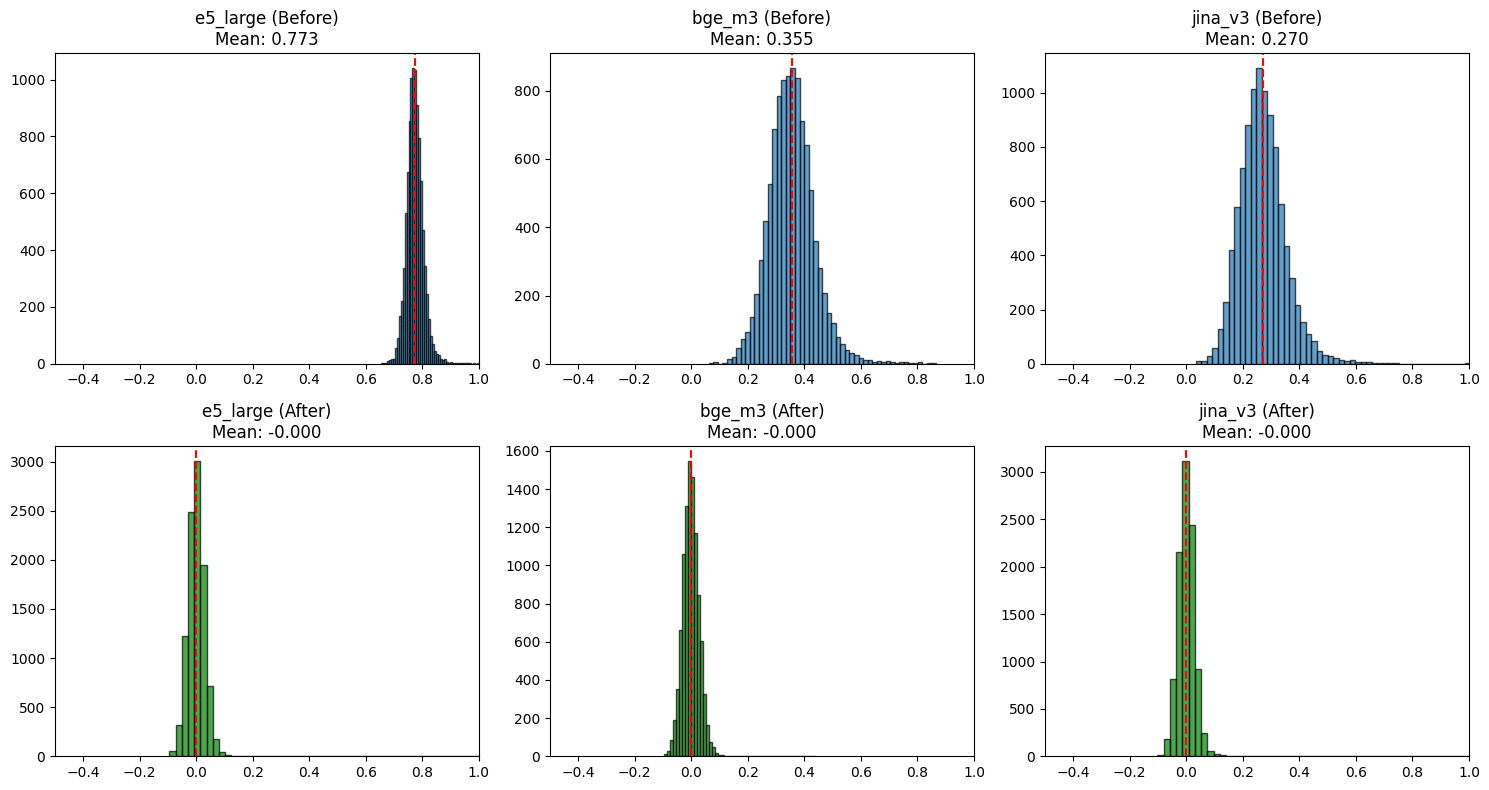

In [7]:
# コサイン類似度分布の可視化
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

rng = np.random.default_rng(42)
sample_size = 10000

for i, model in enumerate(models):
    # Before
    emb = embeddings_dict[model]
    n = len(emb)
    idx1, idx2 = rng.integers(0, n, size=sample_size), rng.integers(0, n, size=sample_size)
    cos_sims_before = np.sum(emb[idx1] * emb[idx2], axis=1)
    
    axes[0, i].hist(cos_sims_before, bins=50, edgecolor='black', alpha=0.7)
    axes[0, i].axvline(x=np.mean(cos_sims_before), color='r', linestyle='--')
    axes[0, i].set_title(f'{model} (Before)\nMean: {np.mean(cos_sims_before):.3f}')
    axes[0, i].set_xlim(-0.5, 1.0)
    
    # After
    emb_w = whitened_embeddings[model]
    cos_sims_after = np.sum(emb_w[idx1] * emb_w[idx2], axis=1)
    
    axes[1, i].hist(cos_sims_after, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, i].axvline(x=np.mean(cos_sims_after), color='r', linestyle='--')
    axes[1, i].set_title(f'{model} (After)\nMean: {np.mean(cos_sims_after):.3f}')
    axes[1, i].set_xlim(-0.5, 1.0)

plt.tight_layout()
plt.show()

## 5. ハミング距離との相関

In [8]:
def compute_hamming_correlation(embeddings, sample_pairs=5000, seed=42):
    """Compute correlation between hamming distance and cosine similarity."""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    gen = SimHashGenerator(dim=embeddings.shape[1], hash_bits=128, seed=42)
    hashes = gen.hash_batch(embeddings)
    
    idx1 = rng.integers(0, n, size=sample_pairs)
    idx2 = rng.integers(0, n, size=sample_pairs)
    
    cos_sims = np.sum(embeddings[idx1] * embeddings[idx2], axis=1)
    ham_dists = np.array([hamming_distance(hashes[i], hashes[j]) for i, j in zip(idx1, idx2)])
    
    corr = np.corrcoef(cos_sims, ham_dists)[0, 1]
    return corr

print('=== ハミング距離相関 (128bit SimHash) ===')
print('\nBefore whitening:')
for model, emb in embeddings_dict.items():
    corr = compute_hamming_correlation(emb)
    print(f'  {model}: {corr:.3f}')

print('\nAfter whitening:')
for model, emb in whitened_embeddings.items():
    corr = compute_hamming_correlation(emb)
    print(f'  {model}: {corr:.3f}')

=== ハミング距離相関 (128bit SimHash) ===

Before whitening:
  e5_large: -0.462
  bge_m3: -0.532
  jina_v3: -0.566

After whitening:
  e5_large: -0.235
  bge_m3: -0.232
  jina_v3: -0.194


## 6. Recall@10 評価

In [9]:
def evaluate_lsh_recall(embeddings, num_queries=50, top_k=10, num_chunks=8, step2_top_n=100, seed=42):
    """Evaluate LSH cascade search recall."""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    gen = SimHashGenerator(dim=embeddings.shape[1], hash_bits=128, seed=42)
    hashes = gen.hash_batch(embeddings)
    chunks_list = [chunk_hash(h, num_chunks) for h in hashes]
    
    recalls = []
    
    for _ in range(num_queries):
        query_idx = rng.integers(0, n)
        query_vec = embeddings[query_idx]
        query_hash = hashes[query_idx]
        query_chunks = chunks_list[query_idx]
        
        cos_sims = np.dot(embeddings, query_vec)
        gt_indices = set(np.argsort(cos_sims)[-top_k:][::-1])
        
        candidates = [i for i, chunks in enumerate(chunks_list) if any(c in query_chunks for c in chunks)]
        
        if len(candidates) == 0:
            recalls.append(0.0)
            continue
        
        ham_dists = [(i, hamming_distance(query_hash, hashes[i])) for i in candidates]
        ham_dists.sort(key=lambda x: x[1])
        step2_candidates = [i for i, _ in ham_dists[:step2_top_n]]
        
        final_scores = [(i, np.dot(query_vec, embeddings[i])) for i in step2_candidates]
        final_scores.sort(key=lambda x: x[1], reverse=True)
        lsh_indices = set(i for i, _ in final_scores[:top_k])
        
        recall = len(gt_indices & lsh_indices) / top_k
        recalls.append(recall)
    
    return np.mean(recalls), np.std(recalls)

def evaluate_lsh_recall_no_chunk(embeddings, num_queries=50, top_k=10, step2_top_n=100, seed=42):
    """Evaluate without chunk filtering."""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    gen = SimHashGenerator(dim=embeddings.shape[1], hash_bits=128, seed=42)
    hashes = gen.hash_batch(embeddings)
    
    recalls = []
    
    for _ in range(num_queries):
        query_idx = rng.integers(0, n)
        query_vec = embeddings[query_idx]
        query_hash = hashes[query_idx]
        
        cos_sims = np.dot(embeddings, query_vec)
        gt_indices = set(np.argsort(cos_sims)[-top_k:][::-1])
        
        ham_dists = [(i, hamming_distance(query_hash, hashes[i])) for i in range(n)]
        ham_dists.sort(key=lambda x: x[1])
        step2_candidates = [i for i, _ in ham_dists[:step2_top_n]]
        
        final_scores = [(i, np.dot(query_vec, embeddings[i])) for i in step2_candidates]
        final_scores.sort(key=lambda x: x[1], reverse=True)
        lsh_indices = set(i for i, _ in final_scores[:top_k])
        
        recall = len(gt_indices & lsh_indices) / top_k
        recalls.append(recall)
    
    return np.mean(recalls), np.std(recalls)

In [10]:
# Recall@10 比較
print('=== Recall@10 比較 ===')

results = []

for model in models:
    emb_before = embeddings_dict[model]
    emb_after = whitened_embeddings[model]
    
    # Before
    r_no_chunk_before, _ = evaluate_lsh_recall_no_chunk(emb_before)
    r_chunk8_before, _ = evaluate_lsh_recall(emb_before, num_chunks=8)
    r_chunk16_before, _ = evaluate_lsh_recall(emb_before, num_chunks=16)
    
    # After
    r_no_chunk_after, _ = evaluate_lsh_recall_no_chunk(emb_after)
    r_chunk8_after, _ = evaluate_lsh_recall(emb_after, num_chunks=8)
    r_chunk16_after, _ = evaluate_lsh_recall(emb_after, num_chunks=16)
    
    results.append({
        'Model': model,
        'NoChunk_Before': r_no_chunk_before,
        'NoChunk_After': r_no_chunk_after,
        'Chunk8_Before': r_chunk8_before,
        'Chunk8_After': r_chunk8_after,
        'Chunk16_Before': r_chunk16_before,
        'Chunk16_After': r_chunk16_after,
    })
    
    print(f'\n{model}:')
    print(f'  NoChunk: {r_no_chunk_before:.3f} -> {r_no_chunk_after:.3f}')
    print(f'  Chunk8:  {r_chunk8_before:.3f} -> {r_chunk8_after:.3f}')
    print(f'  Chunk16: {r_chunk16_before:.3f} -> {r_chunk16_after:.3f}')

df_results = pd.DataFrame(results)
df_results

=== Recall@10 比較 ===

e5_large:
  NoChunk: 0.464 -> 0.334
  Chunk8:  0.402 -> 0.104
  Chunk16: 0.464 -> 0.204

bge_m3:
  NoChunk: 0.670 -> 0.320
  Chunk8:  0.186 -> 0.104
  Chunk16: 0.616 -> 0.230

jina_v3:
  NoChunk: 0.672 -> 0.336
  Chunk8:  0.170 -> 0.100
  Chunk16: 0.572 -> 0.228


,Model,NoChunk_Before,NoChunk_After,Chunk8_Before,Chunk8_After,Chunk16_Before,Chunk16_After
0,e5_large,0.464,0.334,0.402,0.104,0.464,0.204
1,bge_m3,0.670,0.320,0.186,0.104,0.616,0.230
2,jina_v3,0.672,0.336,0.170,0.100,0.572,0.228


## 7. 評価レポート

### 実験結果サマリー

#### 分布の変化（ホワイトニングは成功）

| モデル | Cos_Mean (Before→After) | Cos_Std (Before→After) | Top10VarRatio (Before→After) |
|--------|-------------------------|------------------------|------------------------------|
| E5-large | 0.773 → **-0.001** | 0.030 → 0.029 | 0.222 → **0.019** |
| BGE-M3 | 0.354 → **-0.000** | 0.083 → **0.029** | 0.253 → **0.018** |
| Jina-v3 | 0.270 → **-0.000** | 0.083 → **0.029** | 0.186 → **0.018** |

- 平均が0近くに → **中心化成功**
- Top10分散比率が低下 → **分散の均等化成功**
- 数学的にはホワイトニングは正しく動作している

#### ハミング距離相関（悪化）

| モデル | Before | After | 変化 |
|--------|--------|-------|------|
| E5-large | -0.462 | **-0.235** | 悪化 |
| BGE-M3 | -0.532 | **-0.232** | 悪化 |
| Jina-v3 | -0.566 | **-0.194** | 悪化 |

#### Recall@10（大幅悪化）

| モデル | NoChunk Before→After | Chunk8 Before→After | Chunk16 Before→After |
|--------|----------------------|---------------------|----------------------|
| E5-large | 0.464→**0.334** (-28%) | 0.402→**0.104** (-74%) | 0.464→**0.204** (-56%) |
| BGE-M3 | 0.670→**0.320** (-52%) | 0.186→**0.104** (-44%) | 0.616→**0.230** (-63%) |
| Jina-v3 | 0.672→**0.336** (-50%) | 0.170→**0.100** (-41%) | 0.572→**0.228** (-60%) |

---

### 失敗の原因分析

#### 1. ホワイトニングがセマンティック構造を破壊

PCAホワイトニングは**グローバルな共分散**を単位行列に近づける変換。
しかし、これは**ローカルな近傍関係**を保存しない。

```
Before: 「猫」と「犬」は近い、「猫」と「車」は遠い
After:  全体の分散は均等だが、「猫」と「犬」の相対距離が変化
```

#### 2. SimHashの前提との不整合

SimHashは**角度ベース**のハッシュ（ランダム超平面との内積の符号）。
ホワイトニングは角度を変えてしまうため、SimHashの locality-sensitive 特性が損なわれる。

#### 3. 「同じデータで学習・評価」は問題ではない

**過学習の可能性について検討:**

| 仮説 | 検証 | 結論 |
|------|------|------|
| 同じデータで過学習？ | 過学習なら訓練データでは性能向上するはず | **否定** |
| データ不足？ | 10,000件は十分（1024次元に対して約10倍） | **否定** |

過学習であれば、同じデータでの評価は**良く見える**はず。
実際には**悪化**しているため、過学習ではなく**手法自体の問題**。

#### 4. 真の原因: 近傍関係の非保存

ホワイトニングは以下を最適化する変換:
- グローバルな分散の均等化 ✓
- 次元間の相関除去 ✓

しかし、以下は保証しない:
- **ローカルな近傍関係の保存** ✗
- **元の類似度順序の保存** ✗

LSHの精度は「近いものが近いままか」に依存するため、この保証がないと精度が低下する。

---

### 結論

| 項目 | 結論 |
|------|------|
| **PCAホワイトニング** | LSH精度向上には**効果なし**（むしろ悪化） |
| **過学習の可能性** | **なし**（同じデータで悪化は過学習では説明できない） |
| **根本原因** | ホワイトニングはローカル近傍関係を保存しない |

---

### 推奨アプローチ（今後の検討）

| 優先度 | アプローチ | 期待効果 |
|--------|-----------|----------|
| **1** | **モデル変更 + チャンクなし** | Recall 0.67（既に検証済み、最良） |
| 2 | step2_top_n 増加（100→500） | Recall 向上見込み |
| 3 | Multi-probe LSH | チャンクマッチの false negative 軽減 |
| 4 | 異なるLSH手法（E2LSH等） | 角度ではなく距離ベース |

### 学んだこと

> **「分布を均等にする」≠「LSH精度が上がる」**
>
> Embeddingの異方性（狭いコーン）は見かけ上の問題であり、
> LSHの精度はローカルな近傍関係の保存度に依存する。
> グローバルな分布改善は必ずしも精度向上につながらない。